In [1]:
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
import torch.optim as optim
from probe_experiment import ProbeExperiment
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from io_utils import *
from math import ceil

In [2]:
keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye']

annotations = read_pkl('data/filtered_annotations.pkl')
annotations.sort(key = lambda ant : ant['f_name'])

from annotated_datasets import *
train_ants = annotations[:int(len(annotations)*0.9)]
test_ants = annotations[int(len(annotations)*0.9):]
train_dataset = SPBoWDataset(train_ants, keywords)
test_dataset = SPBoWDataset(test_ants, keywords)
train_dataset = load_to_memory(train_dataset)
test_dataset = load_to_memory(test_dataset)

from torch.utils.data import DataLoader
def get_train_loader():
    return DataLoader(train_dataset, shuffle=True, batch_size=512)

def get_test_loader():
    return DataLoader(test_dataset, shuffle=False, batch_size=512)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23407/23407 [00:50<00:00, 464.54it/s]


### Probing Raw Board State

In [3]:
feat_model = nn.Flatten()

In [4]:
linear_probe = nn.Linear(8*19*19, len(keywords)).cuda() 
probe_model = linear_probe

In [5]:
exp = ProbeExperiment(get_train_loader, get_test_loader, feat_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(probe_model.parameters(), lr=0.003)
config = {'name':'bs_probe', 'write_log':False, 'progress_bar':True, 'save_ckpt':False}
exp.run(probe_model, criterion, optimizer, 5, config)

  1%|█▌                                                                                                                          | 5/412 [00:00<00:09, 42.01it/s]

[LOG] epoch 0 loss 0.166142, new best


  0%|▌                                                                                                                           | 2/412 [00:00<00:22, 17.85it/s]

[LOG] epoch 1 loss 0.168610


  1%|█▌                                                                                                                          | 5/412 [00:00<00:08, 47.16it/s]

[LOG] epoch 2 loss 0.169635


  1%|█▊                                                                                                                          | 6/412 [00:00<00:07, 51.85it/s]

[LOG] epoch 3 loss 0.171094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:09<00:00, 44.52it/s]


[LOG] epoch 4 loss 0.173758


In [6]:
preds, labels = exp.get_predictions(probe_model, get_test_loader())

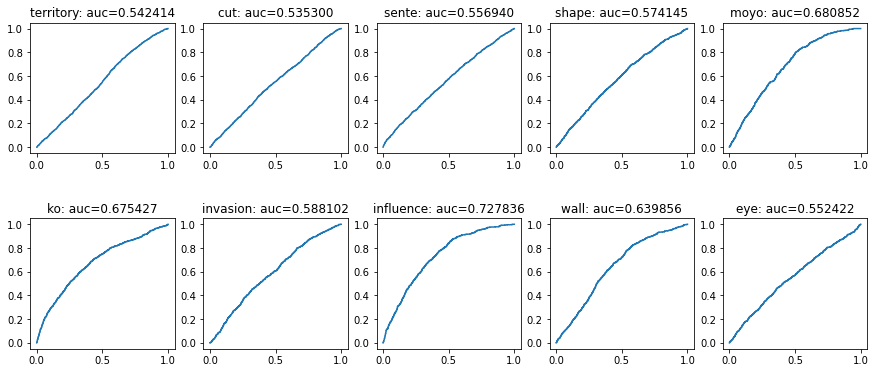

In [7]:
cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_preds, kw_labels = preds[:,kw], labels[:,kw]
    fprs, tprs, _ = roc_curve(kw_labels, kw_preds)
    auc = roc_auc_score(kw_labels, kw_preds)
    axs[kw//cols][kw%cols].plot(fprs, tprs)
    axs[kw//cols][kw%cols].set_title('%s: auc=%f' % (keywords[kw], auc))

In [8]:
from models import *
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
feat_model = nn.Sequential(CutModel(go_model, 7), nn.Flatten()).cuda()

In [9]:
linear_probe = nn.Linear(11552, len(keywords)).cuda() 
probe_model = linear_probe

In [10]:
exp = ProbeExperiment(get_train_loader, get_test_loader, feat_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(probe_model.parameters(), lr=0.003)
config = {'name':'final_layer_probe', 'write_log':False, 'progress_bar':True, 'save_ckpt':False}
exp.run(probe_model, criterion, optimizer, 5, config)

  0%|                                                                                                                                    | 0/412 [00:00<?, ?it/s]

[LOG] epoch 0 loss 0.163286, new best


  0%|▌                                                                                                                           | 2/412 [00:00<00:21, 18.69it/s]

[LOG] epoch 1 loss 0.163747


  1%|▉                                                                                                                           | 3/412 [00:00<00:20, 20.40it/s]

[LOG] epoch 2 loss 0.164410


  1%|▉                                                                                                                           | 3/412 [00:00<00:21, 18.63it/s]

[LOG] epoch 3 loss 0.166134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:27<00:00, 15.24it/s]


[LOG] epoch 4 loss 0.166675


In [11]:
preds_fl, labels_fl = exp.get_predictions(probe_model, get_test_loader())

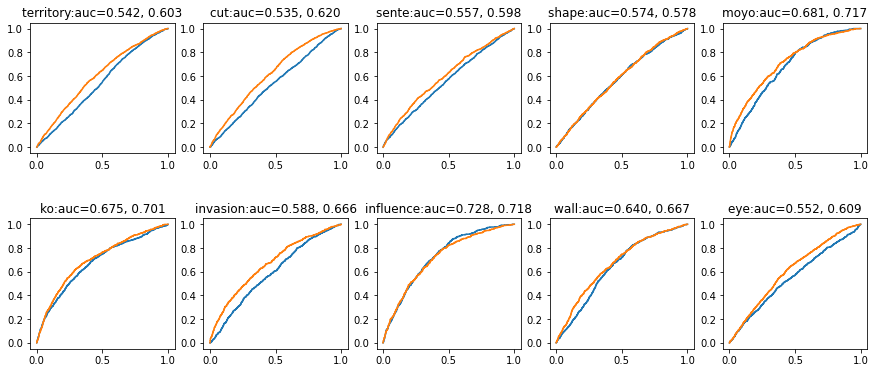

In [12]:
cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_preds, kw_labels = preds[:,kw], labels[:,kw]
    kw_preds_fl, kw_labels_fl = preds_fl[:,kw], labels_fl[:,kw]
    fprs, tprs, _ = roc_curve(kw_labels, kw_preds)
    fprs_fl, tprs_fl, _ = roc_curve(kw_labels_fl, kw_preds_fl)
    auc = roc_auc_score(kw_labels, kw_preds)
    auc_fl = roc_auc_score(kw_labels_fl, kw_preds_fl)
    axs[kw//cols][kw%cols].plot(fprs, tprs)
    axs[kw//cols][kw%cols].plot(fprs_fl, tprs_fl)
    axs[kw//cols][kw%cols].set_title('%s:auc=%.3f, %.3f' % (keywords[kw], auc, auc_fl))